In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import savemat
import math
from loading_real_wave_noise import loading_real_wave_noise
from Reading_path_test import loading_paths_from_MAT
from Control_filter_selection_pre_now import Control_filter_selection_pre_now
from Control_filter_selection import Control_filter_selection
from Fixed_filter_noise_cancellation_subfilters import Fixed_filter_controller
from Disturbance_generation import Disturbance_generation_from_real_noise
from FxLMS_algorithm import FxLMS, train_fxlms_algorithm

print(torch.cuda.is_available())

True


In [2]:
# real noises
mdict = {}
fs = 16000
StepSize = 0.0001
sound_name = 'Helicopter'
waveform, resample_rate = loading_real_wave_noise(folde_name='Noise Examples/Real_noises/', sound_name=sound_name+'.wav')

In [3]:
Pri_path, Secon_path = loading_paths_from_MAT(folder='Pz and Sz', subfolder='Dongyuan', Pri_path_file_name='Primary_path.mat', Sec_path_file_name='Secondary_path.mat')
Dis, Fx, Re = Disturbance_generation_from_real_noise(fs=fs, Repet=0, wave_form=waveform, Pri_path=Pri_path, Sec_path=Secon_path)
# Dis: disturbance (cotrolled noise)， Fx: fixed-x signal, Re: repeated waveform (primary_noise) Repetition=Repet+1

In [4]:
print(waveform.shape)
print(Dis.shape)
print(Fx.shape)
print(Re.shape)

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

torch.Size([1, 160000])
torch.Size([160000])
torch.Size([160000])
torch.Size([160000])


The primary nosie has 10 seconds !!!
1 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
2 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
3 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
4 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
5 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
6 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
7 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
8 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
9 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
10 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]


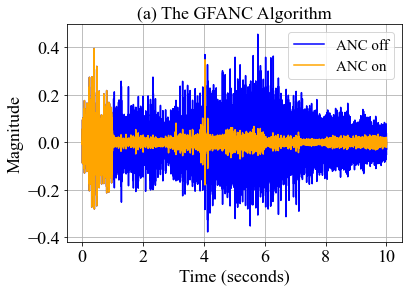

In [5]:
# GFANC: present frame to predict the next

MODEL_PTH = 'models/M6_res_Synthetic.pth'
path_mat = 'models/Pretrained_Sub_Control_filters.mat'

# prediction index
Filter_vector = Control_filter_selection(fs=16000, MODEL_PTH=MODEL_PTH, path_mat=path_mat, Primary_noise=Re.unsqueeze(0), threshold=0.5)

Fixed_Cancellation = Fixed_filter_controller(Filter_vector=Filter_vector, fs=16000)
ErrorGFANC = Fixed_Cancellation.noise_cancellation(Dis=Dis, Fx=Fx)

Time = np.arange(len(Dis))*(1/fs)
Time1 = int(len(Dis)/fs)
plt.rc('font', size=18, family='Times New Roman') # 将plt画图时字号设置为9字体设置为Times New Roman
plt.rc('axes', titlesize=18) # fontsize of the axes title
plt.rc('axes', labelsize=18) # fontsize of the x and y labels
plt.rc('xtick', labelsize=18) # fontsize of the tick labels
plt.rc('ytick', labelsize=18) # fontsize of the tick labels
plt.rc('legend', fontsize=15) # legend fontsize
plt.rc('figure', titlesize=18) # fontsize of the figure title

plt.title('(a) The GFANC Algorithm')
plt.plot(Time, Dis, color='blue', label='ANC off')
plt.plot(Time, ErrorGFANC, color='orange', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
plt.savefig('GFANC.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# SFANC

from scipy.io import loadmat

mat_contents = loadmat('SFANC_Error.mat')
ErrorSFANC = mat_contents['Error']
ErrorSFANC = ErrorSFANC[0]

In [ ]:
# FxLMS

controller = FxLMS(Len=1024) # 1024 is the same size of coeffient vector of fixed-filter
ErrorFxLMS = train_fxlms_algorithm(Model=controller, Ref=Fx, Disturbance=Dis, Stepsize=StepSize) # torch.Size([320000])

plt.title('(c) The FxLMS Algorithm')
plt.plot(Time, Dis, color='blue', label='ANC off')
plt.plot(Time, ErrorFxLMS, color='green', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
plt.savefig('FxLMS.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# compare the Noise_Reduction_Level in every second

def Noise_Reduction_Level_Compute(Disturbance, Error):
    Power_dis = 10*np.log10(np.var(Disturbance))
    Power_err = 10*np.log10(np.var(Error))
    NR_level = Power_dis - Power_err
    return NR_level

if torch.is_tensor(Dis):
    Dis = Dis.numpy() # tensor to numpy
if torch.is_tensor(ErrorGFANC):
    ErrorGFANC = ErrorGFANC.numpy()

a, b, c = [], [], []
a.append(Dis[0])
b.append(Dis[0])
c.append(Dis[0])
Time1 = int(len(Dis)/fs)
for t in range(Time1):
    a.append(Noise_Reduction_Level_Compute(Dis[t*fs:(t+1)*fs], ErrorGFANC[t*fs:(t+1)*fs]))
    b.append(Noise_Reduction_Level_Compute(Dis[t*fs:(t+1)*fs], ErrorSFANC[t*fs:(t+1)*fs]))
    c.append(Noise_Reduction_Level_Compute(Dis[t*fs:(t+1)*fs], ErrorFxLMS[t*fs:(t+1)*fs]))
    
plt.title('(d) Averaged Noise Reduction Level of Every 1s')
plt.step(range(0,Time1+1), c, color='green', label='FxLMS')
plt.step(range(0,Time1+1), b, color='blue', label='SFANC')
plt.step(range(0,Time1+1), a, color='red', label='GFANC')
plt.ylabel('Noise Reduction Level (dB)')
plt.xlabel('Time (seconds)')
plt.xticks(range(0, Time1+1, 1)) # the interval in x
plt.legend()
plt.grid()
plt.savefig('Noise_Reduction_Level.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()